In [93]:
import warnings
warnings.simplefilter('ignore')

In [115]:
import pymc3 as pm
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
import arviz as az

### Task 1: Adjust for confounding on simple fork

The assumption is that if two variables ($X$, $Y$) are causally not connected by  a common cause ($Z$), there will be no association between X and Y conditional on $Z$. Without conditioning on $Z$, however, $X$ and $Y$ will be associated. This will be shown by fitting a linear regression model to simulated data, where the data-generating process if fully known. The conditioning will be done by including Z into the linear regression model. 

In [178]:
# Defining the data generating process

# Defining common cause as normal distributed random variable
# Drawing 100 values from the distribution
sample_size = 100

z = norm(5, 1)
np.random.seed(RANDOM_SEED)
z_values = z.rvs(size=sample_size)

# Defining normally distributed noise
noise = norm(1, 0.5)
noise_values_x = noise.rvs(size=sample_size)
noise_values_y = noise.rvs(size=sample_size)

# Defining X, which is a function of Z and noise
x_values = 0.5 * z_values + noise_values_x

# Defining Y, which is a function of Z and noise
y_values = 10 * z_values + noise_values_y + 1

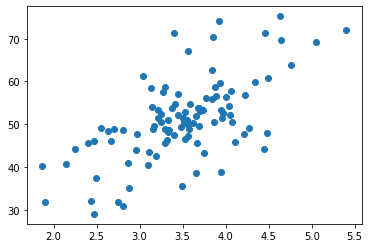

In [179]:
plt.scatter(x_values, y_values)

In [180]:
# Trying to recover the true causal values with bayesian modeling

confounded_model = pm.Model()

with confounded_model:
    
    # Priors for unknown
    intercept = pm.Normal("intercept", mu=0, sigma=10)
    x_infl = pm.Normal("x_infl", mu=0, sigma=10)
    sigma = pm.HalfNormal("sigma", sigma=1)
    
    # Expected value of outcome
    mu = intercept + x_infl * x_values
    
    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=y_values)

In [181]:
map_estimate = pm.find_MAP(model=confounded_model)
map_estimate

{'intercept': array(17.05748671),
 'x_infl': array(9.71998009),
 'sigma_log__': array(1.82523845),
 'sigma': array(6.20427427)}

In [182]:
unconfounded_model = pm.Model()

with unconfounded_model:
    
    # Priors for unknown
    intercept = pm.Normal("intercept", mu=0, sigma=10)
    x_infl = pm.Normal("x_infl", mu=0, sigma=10)
    z_infl = pm.Normal("z_infl", mu=0, sigma=10)
    sigma = pm.HalfNormal("sigma", sigma=1)
    
    # Expected value of outcome
    mu = intercept + x_infl * x_values + z_infl * z_values
    
    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=y_values)

In [183]:
map_estimate = pm.find_MAP(model=unconfounded_model)
print(map_estimate)


{'intercept': array(1.63352266), 'x_infl': array(0.09249431), 'z_infl': array(10.00426013), 'sigma_log__': array(-0.6537574), 'sigma': array(0.52008792)}
